In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGP, MORCGP_shared_noise, MOGPRegressor_NC_bounded_noise, MORCGP_bounded_noise
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
dfs = pd.read_excel(r'FNCL 28-8 11-09.xlsx', sheet_name=["FNCL 5 9 25", "FNCL 5.5 9 25", "FNCL 6 9 25"])
# df_fncl5, df_fncl5_5, df_fncl6 =
df_fncl5 = dfs["FNCL 5 9 25"]
df_fncl5_5 = dfs["FNCL 5.5 9 25"]
df_fncl6 = dfs["FNCL 6 9 25"]
df_fncl5

,Date,Last Price
0,2025-09-11 21:56:36,99-26
1,2025-09-11 21:56:36,99-26
2,2025-09-11 21:56:36,99-26
3,2025-09-11 21:56:36,99-26
4,2025-09-11 20:51:44,99-27+
...,...,...
1875,2025-08-28 13:12:02,98-20
1876,2025-08-28 13:02:02,98-19+
1877,2025-08-28 13:02:02,98-19
1878,2025-08-28 13:02:02,98-19+


In [3]:
def process_last_price(df):
    # Ensure Date is a datetime object
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by Date to ensure "last" is meaningful
    df = df.sort_values(by=['Date'])
    
    # Group by Date and take the last Last Price
    result = df.groupby('Date', as_index=False).last()
    
    return result

fncl5_last_price = process_last_price(df_fncl5)
fncl5_5_last_price = process_last_price(df_fncl5_5)
fncl6_last_price = process_last_price(df_fncl6)
fncl5_last_price

,Date,Last Price
0,2025-08-28 13:02:02,98-19
1,2025-08-28 13:12:02,98-19
2,2025-08-28 13:26:54,98-18+
3,2025-08-28 13:36:52,98-18
4,2025-08-28 13:46:47,98-19
...,...,...
465,2025-09-11 19:46:35,99-26+
466,2025-09-11 19:56:31,99-28
467,2025-09-11 20:06:40,99-28
468,2025-09-11 20:51:44,99-27+


In [4]:
def parse_bloomberg_price(price) -> float:
    if pd.isna(price):
        return None
    
    # Ensure we're working with a string
    price_str = str(price)
    
    # If it's just a plain number, return as float
    if "-" not in price_str:
        return float(price_str)
    
    whole, frac = price_str.split("-")
    whole = int(whole)

    # '+' means an extra 0.5/32
    if frac.endswith("+"):
        frac_val = int(frac[:-1]) + 0.5
    else:
        frac_val = int(frac)

    return whole + frac_val / 32.0

fncl5_last_price["Last Price"] = fncl5_last_price["Last Price"].apply(parse_bloomberg_price)
fncl5_5_last_price["Last Price"] = fncl5_5_last_price["Last Price"].apply(parse_bloomberg_price)
fncl6_last_price["Last Price"] = fncl6_last_price["Last Price"].apply(parse_bloomberg_price)

In [54]:
def merge_price_data(df1, df2, df3, col_names=('fncl5', 'fncl5_5', 'fncl6')):
    """
    Merge three dataframes on the 'Date' column and rename 'Last Price' columns.

    Parameters:
    - df1, df2, df3: pandas DataFrames with columns ['Date', 'Last Price']
    - col_names: tuple of 3 strings for the new column names of 'Last Price'

    Returns:
    - merged_df: pandas DataFrame with columns ['Date', col_names[0], col_names[1], col_names[2]]
    """
    
    # Make copies and rename 'Last Price' to the desired column names
    df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
    df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
    df3_renamed = df3[['Date', 'Last Price']].rename(columns={'Last Price': col_names[2]})
    
    # Merge the three dataframes on 'Date'
    merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer') \
                            .merge(df3_renamed, on='Date', how='outer')
    
    # Optional: sort by Date
    merged_df = merged_df.sort_values('Date').reset_index(drop=True)
    
    return merged_df

merged_df = merge_price_data(fncl5_last_price, fncl5_5_last_price, fncl6_last_price)
merged_df

,Date,fncl5,fncl5_5,fncl6
0,2025-08-28 13:02:02,98.593750,100.656250,102.187500
1,2025-08-28 13:12:02,98.593750,100.562500,NaN
2,2025-08-28 13:16:50,NaN,NaN,102.171875
3,2025-08-28 13:26:54,98.578125,100.546875,NaN
4,2025-08-28 13:32:04,NaN,NaN,102.171875
...,...,...,...,...
661,2025-09-11 20:41:59,NaN,NaN,102.609375
662,2025-09-11 20:51:44,99.859375,101.406250,102.609375
663,2025-09-11 21:51:42,NaN,101.328125,102.562500
664,2025-09-11 21:56:36,99.812500,NaN,NaN


In [42]:
# Rows where either 'fncl5' or 'fncl5_5' has NaN
nan_fncl5_fncl5_5 = merged_df[['fncl5', 'fncl5_5']].isna().any(axis=1).sum()

# Rows where either 'fncl5_5' or 'fncl6' has NaN
nan_fncl5_5_fncl6 = merged_df[['fncl5_5', 'fncl6']].isna().any(axis=1).sum()

print(f"Rows with NaN in 'fncl5' or 'fncl5_5': {nan_fncl5_fncl5_5}")
print(f"Rows with NaN in 'fncl5_5' or 'fncl6': {nan_fncl5_5_fncl6}")

Rows with NaN in 'fncl5' or 'fncl5_5': 220
Rows with NaN in 'fncl5_5' or 'fncl6': 486


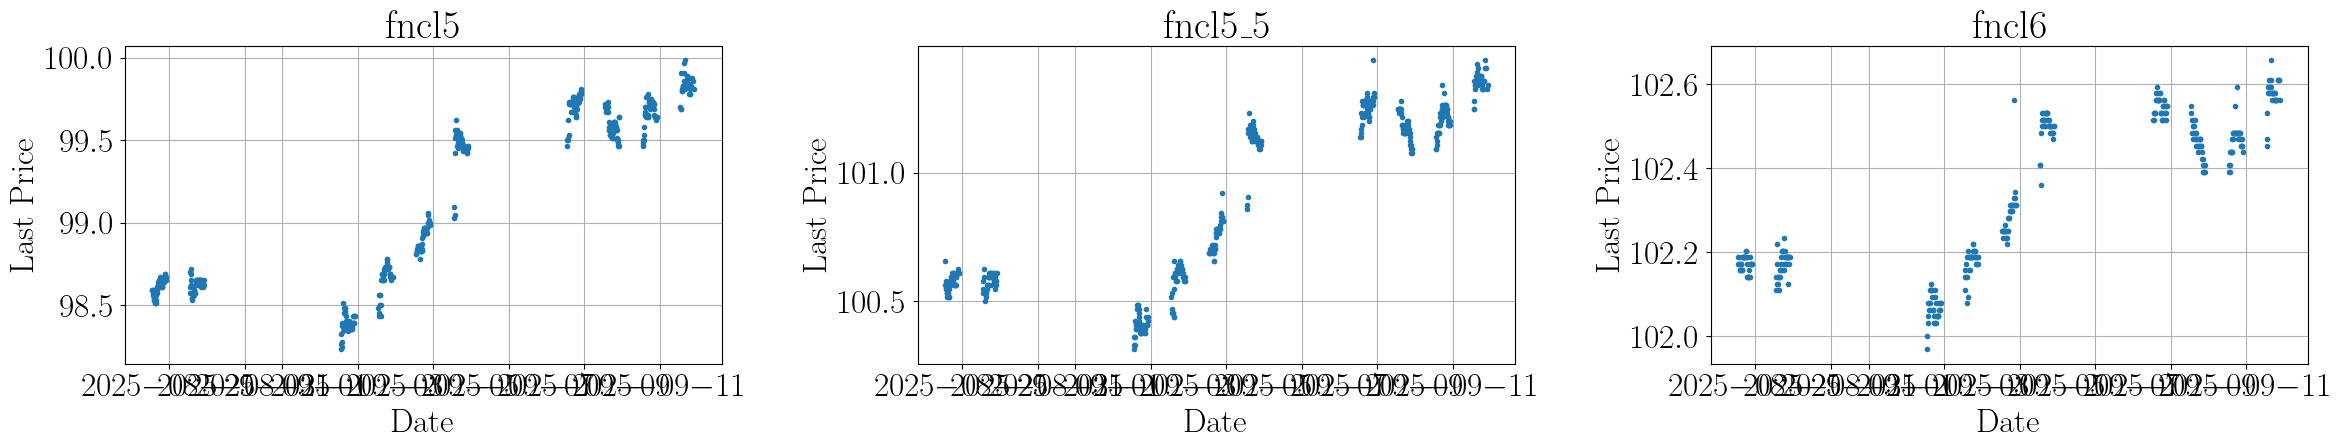

In [41]:
import matplotlib.pyplot as plt

def plot_time_series_grid(df, cols=('fncl5', 'fncl5_5', 'fncl6')):
    """
    Plot time series from a dataframe in a 1x3 grid.

    Parameters:
    - df: pandas DataFrame with a 'Date' column and time series columns
    - cols: tuple/list of column names to plot
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 5), sharex=True)

    for i, col in enumerate(cols):
        axes[i].plot(df['Date'], df[col], marker='o', linestyle='', markersize=3)
        axes[i].set_title(col)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Last Price')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_time_series_grid(merged_df)


In [6]:
def merge_two_prices(df1, df2, col_names=('fncl5', 'fncl5_5')):
    """
    Merge two dataframes on the 'Date' column and rename 'Last Price' columns.

    Parameters:
    - df1, df2: pandas DataFrames with columns ['Date', 'Last Price']
    - col_names: tuple of 2 strings for the new column names of 'Last Price'

    Returns:
    - merged_df: pandas DataFrame with columns ['Date', col_names[0], col_names[1]]
    """
    
    # Rename 'Last Price' columns
    df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
    df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
    
    # Merge on Date
    merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer')
    
    # Sort by Date
    merged_df = merged_df.sort_values('Date').reset_index(drop=True)
    
    return merged_df

fncl5_fncl5_5 = merge_two_prices(fncl5_last_price, fncl5_5_last_price)

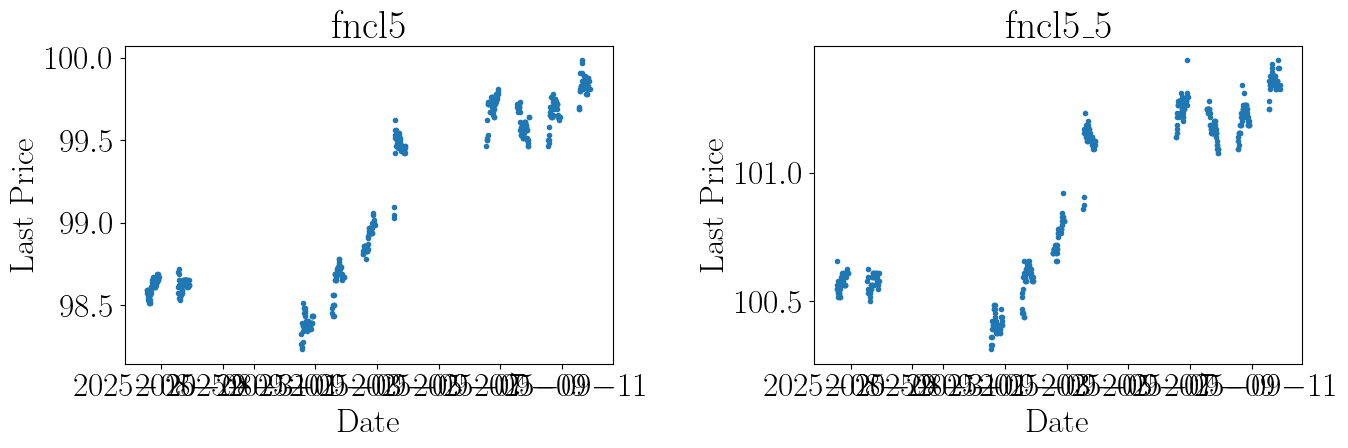

In [7]:
import matplotlib.pyplot as plt

def plot_two_columns(df, col1='fncl5', col2='fncl5_5'):
    """
    Plot two columns from a dataframe in a 1x2 grid.
    
    Parameters:
    - df: pandas DataFrame with 'Date' and the two columns
    - col1, col2: column names to plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    
    # Plot first column
    axes[0].plot(df['Date'], df[col1], marker='o', linestyle='', markersize=3)
    axes[0].set_title(col1)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Last Price')
    
    # Plot second column
    axes[1].plot(df['Date'], df[col2], marker='o', linestyle='', markersize=3)
    axes[1].set_title(col2)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Last Price')
    
    plt.tight_layout()
    plt.show()

plot_two_columns(fncl5_fncl5_5, col1='fncl5', col2='fncl5_5')

In [7]:
import pandas as pd

# Convert the 'Date' column from seconds to datetime
fncl5_fncl5_5['Date'] = pd.to_datetime(fncl5_fncl5_5['Date'], unit='s')

# Extract the date (year-month-day) part only
fncl5_fncl5_5['Day'] = fncl5_fncl5_5['Date'].dt.date

# Get the unique days
unique_days = fncl5_fncl5_5['Day'].unique()

print(unique_days)


[datetime.date(2025, 8, 28) datetime.date(2025, 8, 29)
 datetime.date(2025, 9, 2) datetime.date(2025, 9, 3)
 datetime.date(2025, 9, 4) datetime.date(2025, 9, 5)
 datetime.date(2025, 9, 8) datetime.date(2025, 9, 9)
 datetime.date(2025, 9, 10) datetime.date(2025, 9, 11)]


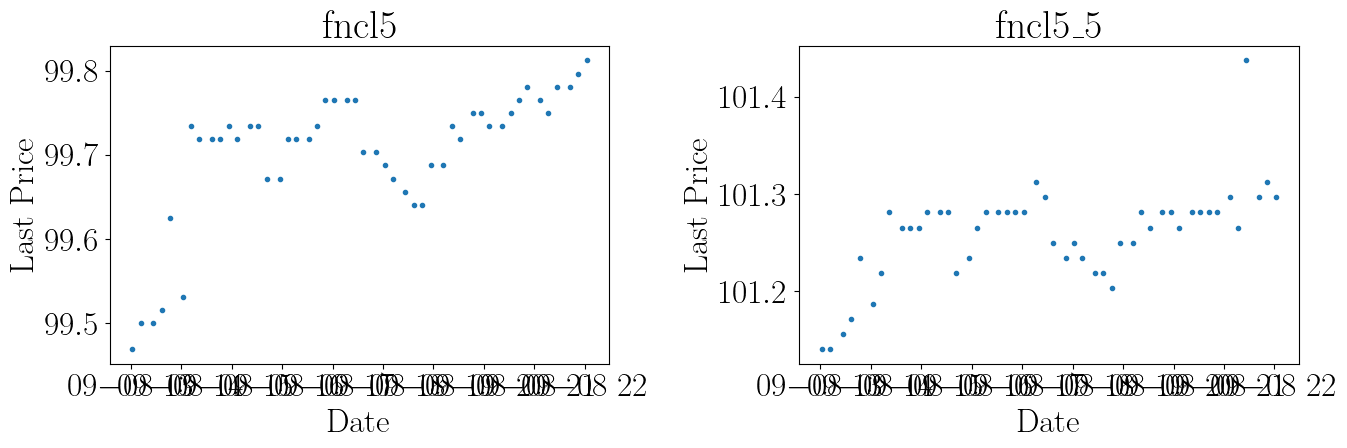

,Date,fncl5,fncl5_5,Day
295,2025-09-08 13:01:48,99.468750,101.140625,2025-09-08
296,2025-09-08 13:11:38,99.500000,101.140625,2025-09-08
297,2025-09-08 13:26:51,99.500000,101.156250,2025-09-08
298,2025-09-08 13:36:43,99.515625,101.171875,2025-09-08
299,2025-09-08 13:46:37,99.625000,101.234375,2025-09-08
300,2025-09-08 14:02:13,99.531250,101.187500,2025-09-08
301,2025-09-08 14:11:38,99.734375,101.218750,2025-09-08
302,2025-09-08 14:21:36,99.718750,101.281250,2025-09-08
303,2025-09-08 14:36:38,99.718750,101.265625,2025-09-08
304,2025-09-08 14:46:43,99.718750,101.265625,2025-09-08


In [8]:
target_date = pd.to_datetime('2025-09-08').date()
df_sept8 = fncl5_fncl5_5[fncl5_fncl5_5['Date'].dt.date == target_date]
plot_two_columns(df_sept8, col1='fncl5', col2='fncl5_5')
df_sept8

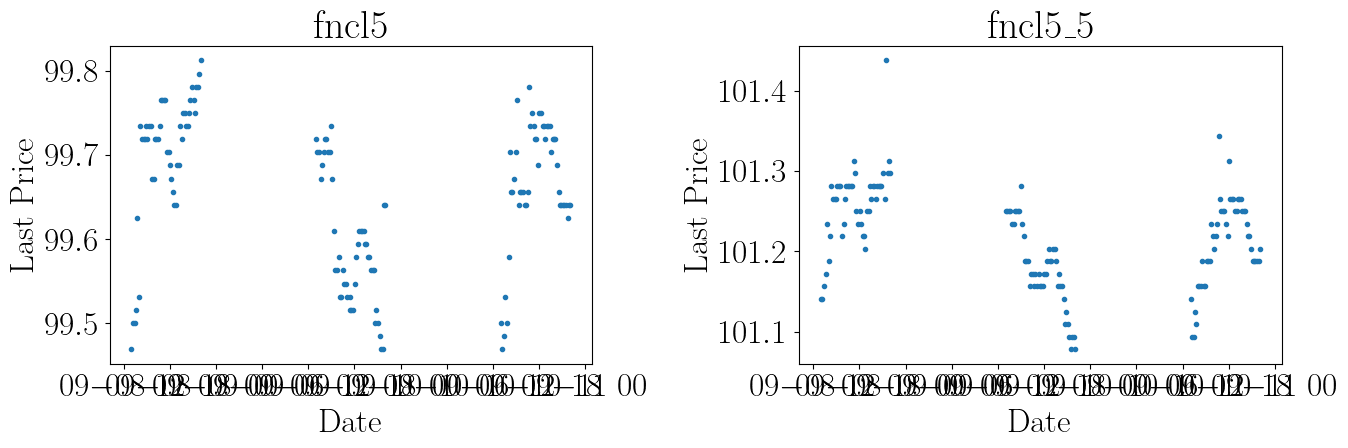

,Date,fncl5,fncl5_5
295,2025-09-08 13:01:48,99.468750,101.140625
296,2025-09-08 13:11:38,99.500000,101.140625
297,2025-09-08 13:26:51,99.500000,101.156250
298,2025-09-08 13:36:43,99.515625,101.171875
299,2025-09-08 13:46:37,99.625000,101.234375
...,...,...,...
439,2025-09-10 21:41:48,NaN,101.187500
440,2025-09-10 21:46:43,99.625000,NaN
441,2025-09-10 21:51:40,99.640625,NaN
442,2025-09-10 21:56:35,NaN,101.187500


In [8]:
# Define the target dates
target_dates = pd.to_datetime(['2025-09-08', '2025-09-09', '2025-09-10']).date

# Filter the dataframe for those dates
df_selected = fncl5_fncl5_5[fncl5_fncl5_5['Date'].dt.date.isin(target_dates)]

# Plot the columns
plot_two_columns(df_selected, col1='fncl5', col2='fncl5_5')

# Display the filtered dataframe
df_selected

In [9]:
import pandas as pd

def convert_date_to_minutes(df, date_col='Date'):
    """
    Convert the date column of a DataFrame to float minutes since the first timestamp.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        date_col (str): Name of the date column (default 'Date').

    Returns:
        pd.DataFrame: DataFrame with the date column replaced by minutes as floats.
    """
    df = df.copy()
    # Ensure the column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Calculate difference from the first timestamp
    df[date_col] = (df[date_col] - df[date_col].iloc[0]).dt.total_seconds() / 60.0

    return df

df_selected_num = convert_date_to_minutes(df_selected)
df_selected_num

,Date,fncl5,fncl5_5
295,0.000000,99.468750,101.140625
296,9.833333,99.500000,101.140625
297,25.050000,99.500000,101.156250
298,34.916667,99.515625,101.171875
299,44.816667,99.625000,101.234375
...,...,...,...
439,3400.000000,NaN,101.187500
440,3404.916667,99.625000,NaN
441,3409.866667,99.640625,NaN
442,3414.783333,NaN,101.187500


In [10]:
df_selected_num['Date'].unique()

array([   0.        ,    9.83333333,   25.05      ,   34.91666667,
         44.81666667,   60.41666667,   69.83333333,   79.8       ,
         94.83333333,  104.91666667,  114.93333333,  124.85      ,
        139.93333333,  149.91666667,  159.86666667,  175.15      ,
        184.9       ,  194.86666667,  209.96666667,  219.91666667,
        229.8       ,  240.15      ,  254.88333333,  264.86666667,
        274.83333333,  289.83333333,  300.03333333,  309.86666667,
        324.76666667,  334.86666667,  344.75      ,  354.85      ,
        369.76666667,  379.86666667,  390.21666667,  404.73333333,
        414.75      ,  424.76666667,  439.86666667,  449.95      ,
        459.95      ,  469.86666667,  484.9       ,  494.83333333,
        504.93333333,  519.98333333,  529.85      ,  540.2       ,
       1440.43333333, 1449.85      , 1464.98333333, 1474.81666667,
       1484.8       , 1500.15      , 1509.86666667, 1519.91666667,
       1534.86666667, 1544.95      , 1554.98333333, 1565.15   

In [10]:
# X as the Date column
X = df_selected['Date'].to_numpy().reshape(-1,1)

# Y as the fncl5 and fncl5_5 columns
Y = df_selected[['fncl5', 'fncl5_5']].to_numpy()
print(X.shape)
print(Y.shape)

(149, 1)
(149, 2)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_std = scaler_X.fit_transform(X)
Y_std = scaler_Y.fit_transform(Y)

In [12]:
N, D = Y_std.shape

epsilon = 3/149
epsilons = np.array([epsilon, 0])

Y_train_clean = Y_std[~np.isnan(Y_std).any(axis=1)]
mcd = MinCovDet(support_fraction=1-epsilon).fit(Y_train_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)

# MOGP
mogp = MOGPRegressor(mean=0, length_scale=1, noise = np.array([0.1] * D), A = robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
mu_mogp, var_mogp = mogp.predict(X_std)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP   
morcgp = MORCGP(mean=0, length_scale=1, noise_var=np.array([0.1]*D), A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons=epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)
mu_morcgp, var_morcgp = morcgp.predict(X_std)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

In [ ]:
# MOGP shared noise
mogp = MOGPRegressor_NC(mean=0, length_scale=1, noise=0.1, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters()
mu_mogp, var_mogp = mogp.predict(X_std)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP shared noise
morcgp = MORCGP_shared_noise(mean=0, length_scale=1, noise_var=0.1, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)
mu_morcgp, var_morcgp = morcgp.predict(X_std)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

In [51]:
epsilons = np.array([3/149, 3/149])

# MOGP bounded noise
mogp = MOGPRegressor_NC_bounded_noise(mean=0, length_scale=0.05, noise=1e-3, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters()
mu_mogp, var_mogp = mogp.predict(X_std)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP bounded noise
morcgp = MORCGP_bounded_noise(mean=0, length_scale=0.05, noise_var=1e-3, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)
mu_morcgp, var_morcgp = morcgp.predict(X_std)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

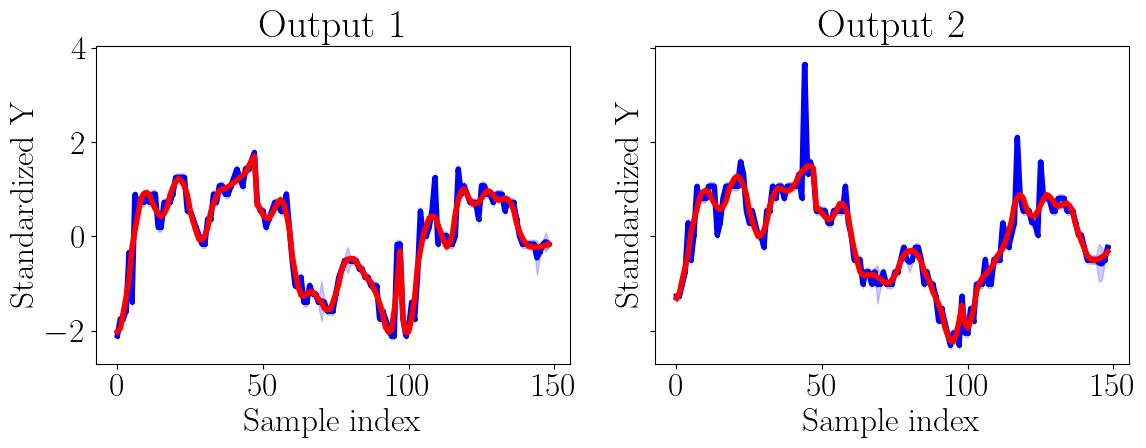

In [52]:
import matplotlib.pyplot as plt

# Number of outputs (columns)
D = Y_std.shape[1]

# Create 1x2 grid
fig, axes = plt.subplots(1, D, figsize=(12, 5), sharex=True, sharey=True)

for d in range(D):
    ax = axes[d]
    
    # Plot the true values
    ax.plot(Y_std[:, d], 'k.', label='True Y')
    
    # Plot MOGP predictions with uncertainty
    ax.plot(mu_mogp[:, d], 'b-', label='MOGP mean')
    ax.fill_between(
        np.arange(len(mu_mogp)),
        mu_mogp[:, d] - 2*std_mogp[:, d],
        mu_mogp[:, d] + 2*std_mogp[:, d],
        color='blue', alpha=0.2
    )
    
    # Plot MORCGP predictions with uncertainty
    ax.plot(mu_morcgp[:, d], 'r-', label='MORCGP mean')
    ax.fill_between(
        np.arange(len(mu_morcgp)),
        mu_morcgp[:, d] - 2*std_morcgp[:, d],
        mu_morcgp[:, d] + 2*std_morcgp[:, d],
        color='red', alpha=0.2
    )
    
    ax.set_title(f'Output {d+1}')
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Standardized Y')
    # ax.legend()

plt.tight_layout()
plt.show()


In [45]:
morcgp.init_w01.flatten() 

array([0.75062956, 0.90366802, 0.78520884, 0.743226  , 0.80502153,
       0.70296507, 0.70710678, 0.90776068, 0.98931366, 0.98931366,
       0.99844719, 0.90776068, 0.96807132, 0.96807132, 0.9829048 ,
       0.99197974, 0.98931366, 0.90776068, 0.90776068, 0.96807132,
       0.98931064, 0.98931064, 0.90079353, 0.98628655, 0.99935933,
       0.96323297, 0.97261115, 0.99197974, 0.99987435, 0.97684393,
       0.99545095, 0.97261115, 0.97261115, 0.96807132, 0.98931366,
       0.99844837, 0.99844837, 0.99844719, 0.96807132, 0.99844837,
       0.98931064, 0.94369057, 0.98628655, 0.96806634, 0.33667903,
       0.99935858, 0.99714471, 0.91457997, 0.98628315, 0.99935933,
       0.99935933, 0.91458714, 0.99714311, 0.96323297, 0.98628315,
       0.98628315, 0.99935933, 0.99935933, 0.96807132, 0.99197974,
       0.84785862, 0.85544533, 0.85544533, 0.92775938, 0.93407521,
       0.82038128, 0.96025635, 0.98433619, 0.89662458, 0.52799568,
              nan, 0.82038128, 0.86298328, 0.86298328, 0.86298

In [100]:
print(mogp.A)
print(mogp.B)
print(mogp.length_scale)
print(mogp.noise)

[[ 0.89054469  0.3513531 ]
 [ 0.87681041 -0.01541579]]
[[0.91651885 0.77542248]
 [0.77542248 0.76903415]]
0.04528201353549306
0.10815541127723571


In [102]:
print(morcgp.A)
print(morcgp.B)
print(morcgp.length_scale)
print(morcgp.noise_var)

[[1.59176871 0.03011416]
 [1.15487941 0.32769464]]
[[2.53463448 1.84816915]
 [1.84816915 1.44113022]]
0.04879384434960058
0.08568132929772171
